# Урок 7
## Линейная регрессия. Однофакторный дисперсионный анализ

### Задача 1

#### Условие: 
Дана матрица объект-признак

```
X = [[ 1.22401313, 2.30868478, 3.03636353, 2.69287214],
[-0.18757272, 1.30337355, 5.12093014, 3.46363202],
[-0.81094525, 1.82463398, 5.79686488, 1.86159445],
[ 0.75129018, 2.67392052, 3.65529809, 1.66746094],
[ 0.00972362, 1.97367255, 2.50594319, 1.69755173],
[-0.62972637, 0.77750764, 2.84124027, 4.54410559],
[ 2.29536229, 1.81206697, 1.95026215, 1.51874636],
[ 0.0920418 , 2.26971361, 7.47708735, 2.61081203],
[ 2.39252799, 3.17563985, 3.61420599, 5.10773362],
[ 0.54983815, 2.87988651, 1.65752765, 1.59635987]]
```

и значения целевой переменной

```
y = [ 9.26193358, 9.700363 , 8.67214805, 8.74796974, 6.18689108,
7.53312713, 7.57643777, 12.44965478, 14.29010746, 6.68361218]
```

1. Подберите два признака (из четырёх) так, чтобы уровень линейной зависимости целевой переменной от значений этих признаков был максимальным. Другими словами, модель линейной регрессии на этих признаках должна давать наилучший результат.

2. Является ли значимым получившееся уравнение регрессии?

#### Решение:

##### Пункт 1:

In [38]:
import numpy as np

In [39]:
X = np.array([[ 1.22401313, 2.30868478, 3.03636353, 2.69287214],
              [-0.18757272, 1.30337355, 5.12093014, 3.46363202],
              [-0.81094525, 1.82463398, 5.79686488, 1.86159445],
              [ 0.75129018, 2.67392052, 3.65529809, 1.66746094],
              [ 0.00972362, 1.97367255, 2.50594319, 1.69755173],
              [-0.62972637, 0.77750764, 2.84124027, 4.54410559],
              [ 2.29536229, 1.81206697, 1.95026215, 1.51874636],
              [ 0.0920418 , 2.26971361, 7.47708735, 2.61081203],
              [ 2.39252799, 3.17563985, 3.61420599, 5.10773362],
              [ 0.54983815, 2.87988651, 1.65752765, 1.59635987]])

Y = np.array([ 9.26193358, 9.700363 , 8.67214805, 8.74796974, 6.18689108,
               7.53312713, 7.57643777, 12.44965478, 14.29010746, 6.68361218])

Для каждой пары признаков построим модель линейной регрессии.

Считать коэффициенты линейной регрессии будем по формуле:

$$ b = (X^TX)^{-1}X^Ty $$

Т.к. в данной формуле $X$ - расширенная матрица, то необходимо добавить столбец из единиц:
```python
X = np.ones((x.shape[0], 1))
```

Найдем предсказанные значения моделью:

$y_{pred} = X * b$

Найдем ошибки модели:

$E = y - y_{pred}$

Найдем коэффициент детерминации:

$$R^2 = 1 - \frac {\sigma^2_E} {\sigma^2_y}$$

In [40]:
def determ(x: np.array, y: np.array) -> float:
    X_tmp = x.copy()
    
    ones  = np.ones((X_tmp.shape[0], 1))
    X_tmp = np.hstack([ones, X_tmp])
    
    b = np.linalg.inv(X_tmp.T.dot(X_tmp)).dot(X_tmp.T).dot(y)
    
    y_pred = X_tmp.dot(b)
    
    E = y - y_pred
    
    return 1 - E.var() / y.var()

In [50]:
import itertools

R = []
for i, j in itertools.combinations(range(X.shape[1]), 2):
    R.append((i, j, determ(X[:, [i, j]], Y)))

r = sorted(R, key=lambda r: r[2])[-1]
r

(0, 2, 0.7634246238793152)

Получили, что признаки с индексами $0$ и $2$ дают наилучший ответ.

##### Пункт 2:
Проверим значимость этой зависимости с помощью распределение Фишера:

$$ F = \frac {\frac {R^2}{m}}{\frac {1-R^2}{n - m - 1}} $$

Где:

$ m = 2$, 

$k_1 = m$, 

$k_2 = n - m - 1$


In [51]:
m = 2
k_1 = 2
k_2 = X.shape[0] - m - 1

r = r[-1]
F = (r / k_1) / ((1 - r) / k_2)

F

11.29443912292265

Найдем критическую область при $\alpha = 0.05$

In [52]:
from scipy import stats

alpha = 0.05

t = stats.f.ppf(1 - alpha, k_1, k_2)
t

4.73741412777588

Критическая область: 
$$\Omega_\alpha = (4.7374, +\infty)$$

Проверим, попадает ли значение статистики в критическую область:

In [53]:
F > t

True

Попадает, значит уравнение регрессии признается статистически значимым.

### Задача 2
#### Условие: 
Для проведения `A/B-тестирования` сайта интернет-магазина были получены следующие данные: страница `A` была посещена `2509 раз`, из них `77` закончились совершением покупки, страница `B` была посещена `1465 раз`, `60` из них закончились совершением покупки. Является ли значимым отличие конверсии на страницах `A` и `B`?

#### Решение:

В данном случае можно применить однофакторный дисперсионный анализ.

Для каждой страницы построим выборку совершения покупки:

1 - была покупка

0 - покупки не было


In [56]:
n1 = 2509
n2 = 1465

y1 = np.zeros(n1)
y1[np.arange(77)] = 1

y2 = np.zeros(n2)
y2[np.arange(60)] = 1

y = np.concatenate([y1, y2])
n = n1 + n2

Найдем средние значения:

In [57]:
y1_mean = y1.mean()
y2_mean = y2.mean()

y_mean = y.mean()

y1_mean, y2_mean, y_mean

(0.03068951773614986, 0.040955631399317405, 0.03447408152994464)

Найдем значения $SS_b$, $SS_w$

In [58]:
SS_b = n1 * (y1_mean - y_mean)**2 + n2 * (y2_mean - y_mean)**2

SS_w = ((y1 - y1_mean)**2).sum() + ((y2 - y2_mean)**2).sum()

SS_b, SS_w

(0.09748158004016791, 132.17956925035745)

Найдем дисперсии:

In [59]:
k = 2

k_1 = k - 1
k_2 = n - k

sigma2_b = SS_b / k_1
sigma2_w = SS_w / k_2

sigma2_b, sigma2_w

(0.09748158004016791, 0.03327783717279895)

Найдем значение статистики:


In [60]:
F = sigma2_b / sigma2_w
F

2.9293243889013496

Найдем критическую область при $\alpha = 0.05$:

In [61]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k_1, k_2)
t

3.8438010503414866

Критическая область: 
$$\Omega_\alpha = (3.8438, +\infty)$$

Проверим, попадает ли значение статистики в критическую область:

In [62]:
F > t

False

Значение статистики не попало в критическую область, сл-но конверсия на страницах `A` и `B` не имеет значимого отличия

### Задача 3

#### Условие:
__Квартет Энскомба__ — популярный в области анализа данных пример наборов данных, у которых практически совпадают все статистические свойства (средние, дисперсии, коэффициенты корреляции, регрессионные линии), однако, существенно отличаются графики. Данный пример призван показать, насколько важна визуализация данных. Датасет представляет собой 4 пары выборок:

```json
{
    "x1": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y1": [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    "x2": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y2": [9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74],
    "x3": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y3": [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73],
    "x4": [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 19.0, 8.0, 8.0, 8.0],
    "y4": [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89]
}
```
По каждой паре выборок посчитайте:

1. выборочное среднее и дисперсию каждой выборки,
2. коэффициент корреляции Пирсона и прямую линейной регрессии.

Убедившись в том, что они не практически не отличаются, постройте `scatter plot` по каждой паре выборок.

#### Решение:

In [63]:
df = {
    "x1": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y1": [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    "x2": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y2": [9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74],
    "x3": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y3": [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73],
    "x4": [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 19.0, 8.0, 8.0, 8.0],
    "y4": [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89]
}

In [71]:
for i in range(1, len(df.keys()) // 2 + 1):
    x, y = df[f'x{i}'], df[f'y{i}']
    
    print(f'Выборка №{i}:')
    print(f'Выборочные средние: \t{np.mean(x)}\t{np.mean(y)}')
    print(f'Выборочные диспресии: \t{np.var(x)}\t{np.var(y)}')
    print(f'Коэффициент корреляции Пирсона:\t{np.corrcoef(x, y)[0, 1]}')
    print('='*50)


    

Выборка №1:
Выборочные средние: 	9.0	7.500909090909093
Выборочные диспресии: 	10.0	3.7520628099173554
Коэффициент корреляции Пирсона:	0.81642051634484
Выборка №2:
Выборочные средние: 	9.0	7.50090909090909
Выборочные диспресии: 	10.0	3.752390082644628
Коэффициент корреляции Пирсона:	0.8162365060002427
Выборка №3:
Выборочные средние: 	9.0	7.5
Выборочные диспресии: 	10.0	3.747836363636364
Коэффициент корреляции Пирсона:	0.8162867394895982
Выборка №4:
Выборочные средние: 	9.0	7.500909090909091
Выборочные диспресии: 	10.0	3.7484082644628103
Коэффициент корреляции Пирсона:	0.8165214368885028


In [72]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Выборка №1: b_0 = 3.0000909090909103	b_1 = 0.5000909090909091
Выборка №2: b_0 = 3.00090909090909	b_1 = 0.5
Выборка №3: b_0 = 3.0024545454545457	b_1 = 0.4997272727272727
Выборка №4: b_0 = 3.0017272727272726	b_1 = 0.4999090909090909


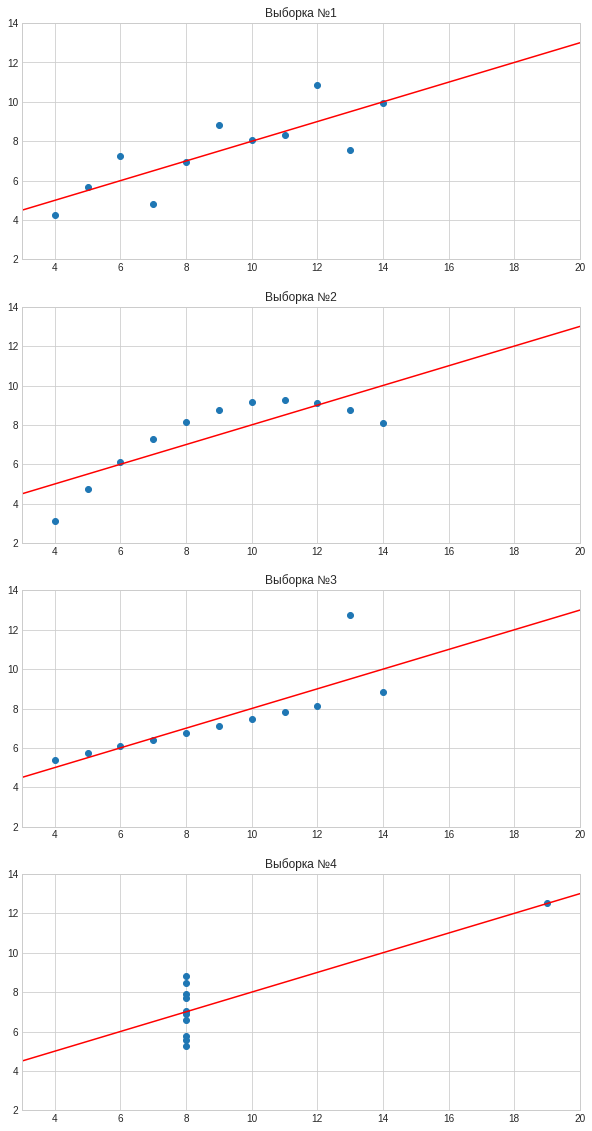

In [80]:
fig, axes = plt.subplots(nrows=4)
fig.set_size_inches(10, 20)

ox = np.linspace(3, 20, 10000)

for i, ax in enumerate(axes.flatten()):
    i += 1
    
    x, y = df[f'x{i}'], df[f'y{i}']
    b_1 = np.cov(x, y, ddof=0)[0,1] / np.var(x, ddof=0)
    b_0 = np.mean(y) - b_1 * np.mean(x)
    
    print(f'Выборка №{i}: b_0 = {b_0}\tb_1 = {b_1}')
    oy = b_0 + b_1 * ox
    
    ax.scatter(x, y)
    ax.plot(ox, oy, c='red')
    
    ax.set_xlim(3, 20)
    ax.set_ylim(2, 14)
    
    ax.set_title(f'Выборка №{i}')